In [2]:
#pip install kagglehub
#!pip install imblearn 
#!pip install imbalanced-learn


In [1]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import imblearn
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

print("Done")

Done


In [2]:
path = kagglehub.dataset_download("henrysue/online-shoppers-intention")


In [1]:
print("Path to dataset files:", path)

NameError: name 'path' is not defined

In [5]:
dataset = pd.read_csv(f"{path}/online_shoppers_intention.csv")
print("Dataset Shape:", dataset.shape)
print("Dataset Preview:")
print(dataset.head())

Dataset Shape: (12330, 18)
Dataset Preview:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00

In [6]:
# Checking for missing values
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [7]:
label_encoder = LabelEncoder() # Encode categorical variables
for column in dataset.select_dtypes(include=['object']).columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

In [8]:
X = dataset.drop(columns=['Revenue'])
y = dataset['Revenue']
print(y)

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12330, dtype: bool


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

In [11]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")


Classification Report:
               precision    recall  f1-score   support

       False       0.91      0.91      0.91      3124
        True       0.52      0.53      0.52       575

    accuracy                           0.85      3699
   macro avg       0.71      0.72      0.72      3699
weighted avg       0.85      0.85      0.85      3699

Accuracy: 0.85
Precision: 0.52
Recall: 0.53


In [25]:
# Preprocessing
# Encode categorical features if needed
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in dataset.select_dtypes(include=['object']).columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

# Separate features and target
X = dataset.drop(columns=['Revenue'])
y = dataset['Revenue']

# Apply SelectKBest to select the top 'k' features
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 3 features (you can adjust k)
k_best = SelectKBest(score_func=f_classif, k=3)
X_new = k_best.fit_transform(X, y)

# Now that we've selected the best features, scale them
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE for oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Separate data by class (after oversampling)
X_train_false = X_train_res[y_train_res == 0]
X_train_true = X_train_res[y_train_res == 1]

# Calculate prior probabilities with class weight adjustment
# Manually adjust the priors (e.g., inversely proportional to class frequency)
class_imbalance_factor = len(y_train_res) / (2 * np.bincount(y_train_res))
p_false = class_imbalance_factor[0] / (class_imbalance_factor[0] + class_imbalance_factor[1])
p_true = class_imbalance_factor[1] / (class_imbalance_factor[0] + class_imbalance_factor[1])

# Function to calculate mean and variance
def calculate_mean_variance(data):
    return np.mean(data, axis=0), np.var(data, axis=0)

# Calculate mean and variance for each class
mean_false, var_false = calculate_mean_variance(X_train_false)
mean_true, var_true = calculate_mean_variance(X_train_true)

# Gaussian probability density function
def gaussian_pdf(x, mean, var):
    return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mean) ** 2 / (2 * var))

def predict(X, threshold=0.7):
    predictions = []
    for i in range(len(X)):
        # Calculate likelihood for each class
        likelihood_false = np.log(p_false)
        likelihood_true = np.log(p_true)
        for j in range(X.shape[1]):  # Use shape[1] for the number of features
            likelihood_false += np.log(gaussian_pdf(X[i, j], mean_false[j], var_false[j]))
            likelihood_true += np.log(gaussian_pdf(X[i, j], mean_true[j], var_true[j]))
        
        # Calculate posterior probabilities (normalized)
        total_likelihood = np.exp(likelihood_false) + np.exp(likelihood_true)
        posterior_false = np.exp(likelihood_false) / total_likelihood
        posterior_true = np.exp(likelihood_true) / total_likelihood
        
        # Apply threshold to decide the class
        if posterior_true >= threshold:
            predictions.append(1)  # Predict "True"
        else:
            predictions.append(0)  # Predict "False"
    return predictions


# Predict on test data
y_pred_manual = predict(X_test)



In [26]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred_manual)
print(f"Accuracy: {accuracy:.2f}")

# Precision
precision = precision_score(y_test, y_pred_manual)
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_test, y_pred_manual)
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(y_test, y_pred_manual)
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.87
Precision: 0.60
Recall: 0.55
F1 Score: 0.57


AUC-ROC: 0.74


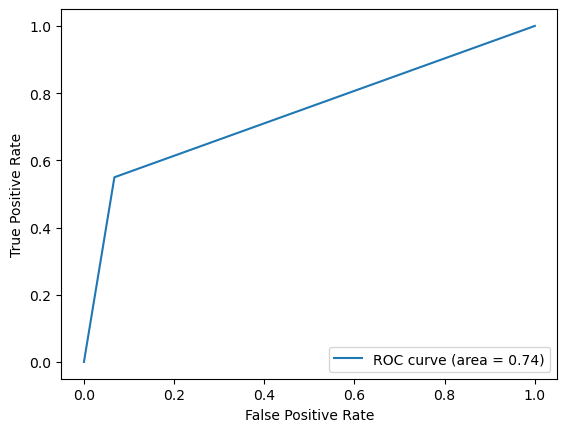

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred_manual)
print(f"AUC-ROC: {auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_manual)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
